In [1]:
import math
from collections import deque

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from pyswarm import pso

In [2]:
#### functions to transform 1-array into triangular inf matrix  and vice versa ####

def i2j_to_k(i, j):
    return i*(i-1)/2 + j


def k_to_i2j(k):
    i = int((1+math.sqrt(1+8*k))/2)
    j = int(k - i*(i-1)/2)
    return (i,j)
    

def d1_2_mat(d):
    l = len(d)
    (n, _) = k_to_i2j(l)
    #print(n)
    mat = np.zeros([n,n])
    for k in range(l):
            (i,j) = k_to_i2j(k)
            mat[i,j] = d[k]
            mat[j,i] = -d[k]
    return mat


def mat_2_d1(mat):
    
    (n,_) = np.shape(mat)
    n-=1
    k_max = int(n*(n-1)/2 + n)
    liste = []
    for k in range(k_max):
        (i,j) = k_to_i2j(k)
        liste.append(mat[k_to_i2j(k)])
        
    return np.array(liste)


def d1_2_mat_list(d, n_Item):
    
    item_list = np.reshape(np.array(d), (n_Item, -1))
    l = len(item_list[0])
    
    (n, _) = k_to_i2j(l)

    mat = np.zeros([n_Item,n,n])
    
    for it in range(n_Item):

        for k in range(l):
                (i,j) = k_to_i2j(k)
                mat[it,i,j] = item_list[it,k]
                mat[it,j,i] = -item_list[it,k]
    return mat


def mat_2_d1_list(mat):
    
    liste_totale = []
    (n_item, n,_) = np.shape(mat)
    n-=1
    k_max = int(n*(n-1)/2 + n)
    for it in range(n_item):
        liste = []
        for k in range(k_max):
            (i,j) = k_to_i2j(k)
            liste.append(mat[it,i,j])
            
        liste_totale+= liste

    return np.array(liste_totale)    

In [3]:
def detection_cooperation(env, id_agent_source, last_offer, full_observation=False): #ratio other agent gave / what I could give
    n_agents = env.n_agents
    agent = env.agents[id_agent_source]
    history = env.transactions_history_numpy
    
    if len(history) < 2:
        return np.zeros(n_agents)
    else:
        # history[-1] holds the transactions of the current round
        # history[-2] holds the transactions of the last round
        last_transaction = history[-2]
    
        if full_observation == True:
            last_trans = last_transaction.sum(1) #what each agent gave
            #last_offer = agent.last_offers[-1]
        else: # partial observation only, the given agent has no view on other agents' transactions
            last_trans = last_transaction[:, id_agent_source] * (n_agents - 1) #what each agent gave
        
        my_offer_max = np.sum(np.maximum(last_offer, 0))
        coop_degrees = np.clip(last_trans/my_offer_max, 0, 1)
    
        return coop_degrees

In [6]:
def TFT(alpha, r, beta=0):
    def function(old_coop_degrees, detected_coop_degrees, r):
        delta = detected_coop_degrees - old_coop_degrees
        r = np.maximum(r + beta*delta, 0)
        output = alpha*old_coop_degrees + (1-alpha)*(r + (1-r)*detected_coop_degrees)        
        return output, r
        
    return function, r

In [7]:
class Agent:
    def __init__(self, id_agent, n_agents, n_items, neg_algo=0):
        self.n_agents = n_agents
        self.n_items = n_items
        self.id_agent = id_agent
        self.old_coop_degrees = np.zeros(self.n_agents)
        self.ut_function = []
        self.last_offers = []
        tft_algo, r = neg_algo
        self.negociation_algo = tft_algo
        self.r = r * np.ones(self.n_agents)
        
    def coop_detection(self, env):
        n_agents = env.n_agents
        id_agent_source = self.id_agent
        if len(self.last_offers) == 0:
            # no last offer
            return np.zeros(n_agents)            
        else:
            # presence last offer(s)
            last_offer = self.last_offers[-1]
            output = detection_cooperation(env, id_agent_source, last_offer)
            return output 
        
    def offer(self, env):
        tran= env.optimize_localy(self.id_agent)
        self.last_offers.append(tran)
        return tran
    
    def negociation(self, detected_coop_degrees):
        output, r_new = self.negociation_algo(self.old_coop_degrees, detected_coop_degrees, self.r)
        self.r = r_new
        self.old_coop_degrees = output
        return output

In [8]:
class Environment:
    def __init__(self, n_agents, n_items, list_agents = []):
        self.n_agents = n_agents
        self.agents = list_agents
        self.n_items = n_items
        self.t = 0 #step 
        self.state = np.zeros([n_agents, n_items])
        self.states_history = [] #history of states
        self.transactions_history = []
        self.transactions_history_numpy = []
        
        self.optimal_SW = 0 #optimal social welfare 
        self.hist_SW = [] #evolution of social welfare
        self.hist_ut_agents = [[] for _ in range(self.n_agents)] #evolution of utilities of agents 
        
        self.hist_coop_degrees = [] #evolution of cooperation degrees
        
        
    def init_state(self, state):
        s = np.copy(state)
        self.state = s
        self.t = 0
        
    def next_round(self):
        self.t += 1
        self.transactions_history.append([])
        self.transactions_history_numpy.append(np.zeros([env.n_agents, env.n_agents]))
        
    def replace_agents(self, list_agents):
        self.agents = list_agents
        
    def clip_state(self, lb, ub):
        self.state = np.clip(self.state, lb, ub)
    
    def random_init(self, mean=0, std=1):
        self.state = np.random.normal(mean, std, size = [self.n_agents, self.n_items])
        
    def transaction(self, id_agent_source, id_agent_target, id_item, quantity):
        self.state[id_agent_target, id_item] += quantity
        self.state[id_agent_source, id_item] -= quantity
        
        self.transactions_history[-1].append((env.t, id_agent_source, id_agent_target, id_item, quantity))
        
        #update quantities shared between agents (independently of items)
        self.transactions_history_numpy[-1][id_agent_source, id_agent_target] += quantity
        
        
        
    def add_transactions_np(self, state, transactions):
        #state : array nA x nI
        #transactions : array nI x nA x nA

        (nA, nI) = np.shape(state)
        new_s = state.copy()
        for item in range(nI):
            for agent in range(nA):
                new_s[agent, item] -= transactions[item, agent, : ].sum()

        return new_s
    
    def add_transactions_var(self, state, trans_var):
        #state : array nA x nI
        #trans_var : variable for optimisation, list
        transactions = d1_2_mat_list(trans_var, self.n_items)
        return self.add_transactions_np(state, transactions)
    

    def global_utility(self, state, lb =-2.0, ub = 100.0):
        s = np.copy(state)
        s = np.clip(s, lb, ub)
        return -np.log(s+2+1e-8).sum()
    
    def local_utility(self, state, id_agent):
        s = np.copy(state)
        s = s[id_agent,:]
        s = np.clip(s, -2, 100)
        return -np.log(s+2+1e-8).sum()
    
    def optimize_localy(self, id_agent, lb = -4, ub = 4, min_cons = -1):
        (nA, nI) = self.n_agents, self.n_items
        size_var = nI #size of variable 
        lb_list = lb * np.ones(size_var) #lower bounds
        ub_list = ub * np.ones(size_var) #upper bounds
        
        s_tmp = np.copy(self.state)
        
        def f_opt(dx): #utility function for pso
            s = np.copy(s_tmp)
            s[id_agent, :] += dx
            return self.local_utility(s, id_agent) + 0.01 * np.linalg.norm(dx)
            
        def constraint(dx):
            s = np.copy(s_tmp)
            s[id_agent, :] += dx       
            s = s[id_agent]        
            const_out1 = s-min_cons
            const_out2 = np.array([-dx.sum()])
            const_out = np.concatenate((const_out1, const_out2))

            return const_out
        
        xopt, fopt = pso(f_opt, f_ieqcons= constraint, lb=lb_list, ub=ub_list, maxiter=200, swarmsize=200)
        
        return(xopt)
    
    
    def optimize_globally(self, lb = -2.0, ub = 2.0):
        (nA, nI) = self.n_agents, self.n_items
        k_max = nI * ( int((nA-1)*(nA-2)/2 + nA-1)  )
        d_var = np.zeros(k_max)
        lb_list = lb*np.ones(k_max)
        ub_list = ub*np.ones(k_max)
        
        s = self.state.copy()
        
        def f_opt(dx):
            
            trans_var_np = d1_2_mat_list(dx, self.n_items)
            new_s_tmp = self.add_transactions_np(s, trans_var_np)
            
            fusion_items = trans_var_np.sum(0)
            received_agents = fusion_items.sum(1)
            
            return self.global_utility(new_s_tmp) + 0.1*np.linalg.norm(received_agents) + 0.1 * np.linalg.norm(dx) 
    
        def constraint(dx):
            
            trans_var_np = d1_2_mat_list(dx, self.n_items)
            new_s_tmp = self.add_transactions_np(s, trans_var_np)
            
            const_out = new_s_tmp - min_cons
            #const_out2 = np.array([-dx.sum()])
            #const_out = np.concatenate((const_out1,const_out2))

            return const_out
    
        xopt, fopt = pso(f_opt, lb_list, ub_list, maxiter=300, swarmsize=300)
        
        transactions = d1_2_mat_list(xopt, self.n_items)
        new_s = self.add_transactions_np(s, transactions)
        #print(new_s)
        
        return(transactions, new_s, env.global_utility(new_s))
        
    def optimal_social_welfare(self):
        (transactions, new_s, fopt) = self.optimize_globally()
        self.optimal_SW = fopt
        return fopt
        
    def get_observation(self, id_agent):
        return self.state[id_agent, :]
    
    
    def allocation(self, coop_degrees, demands):
        
        # demands greater than zero correspond to demands
        agents_demands = np.maximum(demands, 0)
        
        # demands lower than zero correspond to offers
        agents_offers = -np.minimum(demands, 0)
        
        print('agents_demands\n', agents_demands)
        print('agents_offers\n', agents_offers)
        for it in range(self.n_items):
            for agent_source in range(self.n_agents):
                source_offer = agents_offers[agent_source, it]
                
                if source_offer > 0: #agent_source can give source_offer for item it
                    demands_targets = np.zeros([self.n_agents])
                    parts_targets = np.zeros([self.n_agents])  
                    
                    for agent_target in range(self.n_agents):
                        target_demand = agents_demands[agent_target, it] #demand of agent_target if < 0
                        target_demand_clip = min(target_demand, source_offer)
                        demands_targets[agent_target] = target_demand_clip
                        parts_targets[agent_target] = target_demand_clip
                    total_demand = demands_targets.sum()

                    for agent_target in range(self.n_agents):
                        alloc = demands_targets[agent_target]*coop_degrees[agent_source, agent_target]*source_offer 
                        if total_demand != 0:
                            alloc /= total_demand
                        alloc = min(alloc, source_offer)
                        
                        self.transaction(agent_source, agent_target, it, alloc)


    def show(self, debug=False):
        fig, axs = plt.subplots(1, self.n_agents)
        for i in range(self.n_agents):
            axs[i].bar(np.arange(self.n_items),self.get_observation(i), orientation = 'vertical')
            axs[i].axis('equal')

            if debug:
                axs[i].set_title('Agent ' + str(i+1) + ' at step' + str(self.t))
            else:
                axs[i].set_title('Agent ' + str(i+1))
            axs[i].set_ylim([-1,1])

#env = Environment(3,4, agents)     

In [9]:
STATE_B = np.array([
    [-1.0,  2.0,  0.0,  1.0],
    [ 3.0,  1.0, -1.0,  1.0],
    [ 1.0, -1.0,  3.0,  1.0],
    
])

STATE_C = np.array([
    [0.0,2.0,0.0,1.0,-1.0,1.0],
    [2.0,2.0,-1.0,1.0,-1.0,0.0],
    [1.0,-1.0,1.0,-1.0,2.0,1.0],
    
])

STATE_D = np.array([
    [-1.0,  1.0,  0.0,  1.0, -1.0,  1.0],
    [-1.0,  1.0, -1.0,  1.0, -1.0,  0.0],
    [ 1.0, -1.0,  1.0, -1.0,  1.0,  1.0],
    [-1.0,    0,  1.0, -1.0, -1.0,  1.0],
    
])

STATE_E = np.array(
    [
        [-1.,  2.,  2.],
        [ 2.,  2., -1.],
        [ 2., -1.,  2.]
    ])

In [10]:
ALGO_2 = TFT(0.1, 0.2, 0.7)
ALGO_1 = TFT(0.2, 0.1, 0.6)
EGOIST = TFT(1, 0, 0.5)

state = STATE_E
n_agents = len(state)
n_items = len(state[0])

agents = [
    Agent(0, n_agents, n_items, ALGO_1),
    Agent(1, n_agents, n_items, ALGO_1),
    Agent(2, n_agents, n_items, ALGO_1),
    #Agent(3, n_agents, n_items, ALGO_1),
]

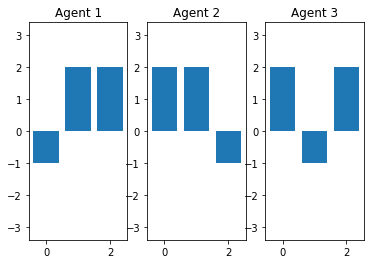

In [11]:
env = Environment(n_agents, n_items, agents) 
env.init_state(state)
#env.init_state(new_s)
env.show()

[]


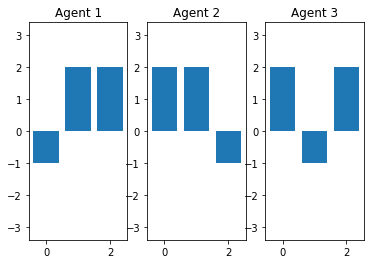

In [12]:
env.show()
print(env.hist_SW)

In [13]:
def episode(env):
    n_agents = env.n_agents
    n_items = env.n_items
    opt_sw = env.optimal_social_welfare()
    print('opt_sw:', opt_sw)
    env.next_round()
    
    env.states_history.append(env.state)
    current_SW = env.global_utility(env.state)
    env.hist_SW.append(current_SW)
    
    for i_A in range(n_agents):
        uti_agent = env.local_utility(env.state, i_A)
        env.hist_ut_agents[i_A].append(uti_agent)
    
    env.show()

        
    
    demands = np.zeros([n_agents, n_items])
    
    
    coop_degrees = np.zeros([n_agents, n_agents])
    
    for i_agent in range(n_agents):
        transa = env.agents[i_agent].offer(env)
        env.agents[i_agent].last_offers.append(transa)
        #print(transa)
        
        print("Agent ",i_agent)
        coop_deg_detected = env.agents[i_agent].coop_detection(env)
        print("coop deg detected ", coop_deg_detected)
        
        coop_deg_i = env.agents[i_agent].negociation(coop_deg_detected)
        print("coop deg negociated ", coop_deg_i)
        print()
        
        
        demands[i_agent, : ] = transa
        coop_degrees[i_agent,:] = coop_deg_i
        
    coop_degrees = np.clip(coop_degrees,0,1)
    
    print('coop_degrees:\n', coop_degrees)
    env.hist_coop_degrees.append(coop_degrees)
    
    print('demands:\n', demands)
    env.allocation(coop_degrees, demands)
    #print(np.sum(env.state, axis=1))

In [14]:
def mean_coop_degrees(matrix_list):
    if matrix_list == []:
        return []
    else:
        (n_A,_) = np.shape(matrix_list[0])
        output = [ [[] for _ in range(n_A)], [[] for _ in range(n_A)] ]  #curves for mean receiving AND sending coop degree 
        for coop_degrees_mat in matrix_list:
            rece_coop = coop_degrees_mat.sum(0)
            send_coop = coop_degrees_mat.sum(1)
            for i_A in range(n_A):
                mean_rece = (rece_coop[i_A] - coop_degrees_mat[i_A,i_A])/(n_A-1)
                output[0][i_A].append(mean_rece)    #receiving coop degree mean for agent i_A

                mean_send = (send_coop[i_A] - coop_degrees_mat[i_A,i_A])/(n_A-1)
                output[1][i_A].append(mean_send)    #receiving coop degree mean for agent i_A

        return output

In [15]:
def figure_utilities(sw, list_ut, output_fig, max_t, lu=2,uu=4):
    colors = ['b','m','c','r']
    t_max = min(len(sw), max_t)
    t = np.arange(t_max)
    
    fig, ax1 = plt.subplots()

    color = 'b'
    ax1.set_xlabel('Rounds', fontsize = 14)
    ax1.set_ylabel('Social Welfare', color='g', fontsize = 14)
    ax1.plot(t, sw[:t_max], color='g', label="Social Welfare")
    ax1.tick_params(axis='y', labelcolor='g', labelsize = 14)
    plt.legend(loc=2, fontsize=13)

    ax2 = ax1.twinx()  
    ax2.set_ylabel('Individual Utility', color=color, fontsize = 14) 
    ax2.set_ylim(lu, uu)
    ax2.tick_params(axis='y', labelcolor=color, labelsize = 14)
    ax1.tick_params(axis='x', labelsize = 14)



    for i_A in range(len(list_ut)):
        color = colors[i_A]
        label = "Agent "+str(i_A+1)
        if i_A == 5:
            label = "Egoist"
        ax2.plot(t, list_ut[i_A][:t_max], color=color, label=label)
    
    plt.legend(loc=4, fontsize=13)
        
    fig.tight_layout() # otherwise the right y-label is slightly clipped
    fig.savefig(output_fig)
    plt.show()

In [16]:
def figure_coop_degrees_mean(list_coop, output_fig, max_t, lc=0 ,uc=1):
    colors = ['b','m','c','g','r']
    
    t_max = min(len(list_coop[0][0]), max_t)
    t = np.arange(t_max)

    fig, ax1 = plt.subplots()

    color = 'b'
    ax1.set_xlabel('Rounds', fontsize=14)
    ax1.set_ylabel('Mean Cooperation Degree',fontsize=14)

    ax1.set_ylim(lc, uc)

    ax1.tick_params(axis='y', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    


    for i_A in range(len(list_coop[0])):
        color = colors[i_A]
        if i_A != 5:
            label = "Agent "+str(i_A+1)
        else:
            label = "Egoist"
        ax1.plot(t, list_coop[0][i_A][:t_max], color, label = label + " : receiving")
        ax1.plot(t, list_coop[1][i_A][:t_max], color+"--", label = label + " : sending")
        plt.legend(loc=4, fontsize=13)
        
    fig.tight_layout() # otherwise the right y-label is slightly clipped
    fig.savefig(output_fig)
    plt.show()

In [17]:
def affiche(env, output, lu, uu, lc, uc):
    y_A = env.hist_ut_agents[0]
    y_B = env.hist_ut_agents[1]
    y_C = env.hist_ut_agents[2]
    #y_D = env.hist_ut_agents[3]
    y = env.hist_SW

    y_A = [-x for x in y_A]
    y_B = [-x for x in y_B]
    y_C = [-x for x in y_C]
    #y_D = [-x for x in y_D]
    y = [-x for x in y]
    
    mean_coop_degrees_expe = mean_coop_degrees(env.hist_coop_degrees)
    
    figure_utilities(y, [y_A, y_B, y_C], 'evolution_utilities_'+output +'.svg',10, lu, uu)
    
    figure_coop_degrees_mean(mean_coop_degrees_expe, 'evolution_cooperation_'+output+'.svg',10, lc, uc)    

In [18]:
env = Environment(3, 3, agents)
env.init_state(STATE_E)

In [19]:
def effiency(list_SW, SWopt):
    SW0 = list_SW[0]
    output = []
    
    for sw in list_SW:
        e = min((-sw+SW0)/(-SWopt+SW0), 1)
        output.append(e)
        
    return output

In [20]:
def speed(list_eff, T):
    final_efficiency = list_eff[-1]
    x = np.arange(T)    
    return metrics.auc(x, list_eff[:T])/(T*final_efficiency)

In [21]:
def analyse(state, beta, r, alpha, N_iter=10):
    algo = TFT(beta, r, alpha)
    egoist = TFT(1, 0, 0.5)

    # n_agents: number of actors, n_items: number of items
    n_agents, n_items = np.shape(state)
    
    T_speed = 10    
    T_speed = min(T_speed, N_iter)

    a1 = Agent(0, n_agents, n_items, algo)
    a2 = Agent(1, n_agents, n_items, algo)
    a3 = Agent(2, n_agents, n_items, algo)

    b1 = Agent(0, n_agents, n_items, algo)
    b2 = Agent(1, n_agents, n_items, algo)
    b3 = Agent(2, n_agents, n_items, egoist)
    
    c1 = Agent(0, n_agents, n_items, algo)
    c2 = Agent(1, n_agents, n_items, egoist)
    c3 = Agent(2, n_agents, n_items, egoist)

    agents_A = [a1, a2, a3]
    agents_B = [b1, b2, b3]
    agents_C = [c1, c2, c3]
    
    env_A = Environment(n_agents, n_items, agents_A)
    env_A.init_state(state)
    
    env_B = Environment(n_agents, n_items, agents_B)
    env_B.init_state(state)
    
    env_C = Environment(n_agents, n_items, agents_C)
    env_C.init_state(state)
    
    tra, ns, swopt = env_A.optimize_globally()
    
    for i_ep in range(N_iter):
        print("Env A, episode ", i_ep)
        episode(env_A)
        
    for i_ep in range(N_iter):
        print("Env B, episode ", i_ep)
        episode(env_B)
        
    for i_ep in range(N_iter):
        print("Env C, episode ", i_ep)
        episode(env_C)
            
    effic = effiency(env_A.hist_SW, swopt)
    
    ef = effic[-1]

    sp = speed(effic, T_speed)
    
    ut_max_pers_nices = -1 * env_A.hist_ut_agents[2][-1] #positive
    ut_pers_3egoist = -1 * env_A.hist_ut_agents[0][0] #positive  
    ut_pers_1egoist = -1 * env_B.hist_ut_agents[2][-1] #positive
    ut_pers_2egoist = -1 * env_C.hist_ut_agents[0][-1] #positive

    print(ut_max_pers_nices, ut_pers_1egoist, ut_pers_2egoist, ut_pers_3egoist)
    
    ic = (ut_max_pers_nices-ut_pers_1egoist) / ut_max_pers_nices
    sf = (ut_pers_2egoist-ut_pers_3egoist)
    
    return [[beta, r, alpha], [env_A, env_B, env_C], ef, sp, ut_max_pers_nices, ut_pers_1egoist, ut_pers_2egoist, ut_pers_3egoist]

state:
 [[-1.  2.  2.]
 [ 2.  2. -1.]
 [ 2. -1.  2.]]
Stopping search: Swarm best objective change less than 1e-08
Env A, episode  0
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.874943903832557
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

coop_degrees:
 [[0.09 0.09 0.09]
 [0.09 0.09 0.09]
 [0.09 0.09 0.09]]
demands:
 [[ 1.94952219 -0.99118627 -0.95833598]
 [-0.94310019 -0.97392185  1.91702107]
 [-0.95515552  1.92735777 -0.97220244]]
agents_demands
 [[1.94952219 0.         0.        ]
 [0.         0.         1.91702107]
 [0.         1.92735777 0.        ]]
agents_offers
 [[-0.          0.9911862

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.02720571 0.37208068 0.        ]
coop deg negociated  [0.21170874 0.49104095 0.1       ]

coop_degrees:
 [[0.1        0.9997952  0.99976688]
 [0.39328871 0.1        0.99993673]
 [0.21170874 0.49104095 0.1       ]]
demands:
 [[ 0.00339783 -0.00242876 -0.00096909]
 [-0.00316742  0.00124247  0.00192473]
 [-0.01524877  0.01626564 -0.00101693]]
agents_demands
 [[0.00339783 0.         0.        ]
 [0.         0.00124247 0.00192473]
 [0.         0.01626564 0.        ]]
agents_offers
 [[-0.          0.00242876  0.00096909]
 [ 0.00316742 -0.         -0.        ]
 [ 0.01524877 -0.          0.00101693]]
Env A, episode  8
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.886844228188123
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.90217516 1.        ]
coop deg negociated  [0.1        0.9207414  0.99997669]

Stopping search: Swarm

Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.856154814212127
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.35032356 0.        ]
coop deg negociated  [0.0999999  0.41666413 0.0999999 ]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.40449013 0.         0.        ]
coop deg negociated  [0.46126599 0.0999999  0.0999999 ]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.10158385 0.11230237 0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.0999999  0.41666413 0.0999999 ]
 [0.46126599 0.0999999  0.0999999 ]
 [0.         0.         0.        ]]
demands:
 [[ 0.96089933 -0.666283   -0.29462301]
 [-0.27226503 -0.66717268  0.93943674]
 [-0.68605648  1.37446036 -0.6884044 ]]
agents_demands
 [[0.96089933 0.         0.        ]
 [0.         0.         0.93943674]
 [0.         1.37446036 0.        ]]
agents_offers
 [

/home/xavier/sharing_resources/sharing_resources/lib/python3.6/site-packages/ipykernel_launcher.py:189: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0. 0. 0.]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0. 0. 0.]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.09 0.09 0.09]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
demands:
 [[ 1.9247616  -0.91052313 -1.01426616]
 [-0.98028051 -0.96117576  1.94145627]
 [-0.98004562  1.93638963 -0.95634401]]
agents_demands
 [[1.9247616  0.         0.        ]
 [0.         0.         1.94145627]
 [0.         1.93638963 0.        ]]
agents_offers
 [[-0.          0.91052313  1.01426616]
 [ 0.98028051  0.96117576 -0.        ]
 [ 0.98004562 -0.          0.95634401]]
Env C, episode  1
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.87260494345069
Stopping search: Swarm best object

Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.818259964359575
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.1 0.1 0.1]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.10177663 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.10731595 0.         0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.1 0.1 0.1]
 [0.  0.  0. ]
 [0.  0.  0. ]]
demands:
 [[ 1.49626887 -0.75740366 -0.73886586]
 [-0.74206679 -0.72394096  1.46600759]
 [-0.70061161  1.44996013 -0.74934854]]
agents_demands
 [[1.49626887 0.         0.        ]
 [0.         0.         1.46600759]
 [0.         1.44996013 0.        ]]
agents_offers
 [[-0.          0.75740366  0.73886586]
 [ 0.74206679  0.72394096 -0.        ]
 [ 0.70061161 -0.          0.74934854]]
Env C, episode 

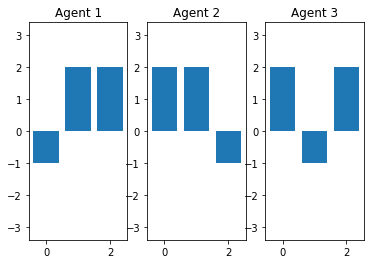

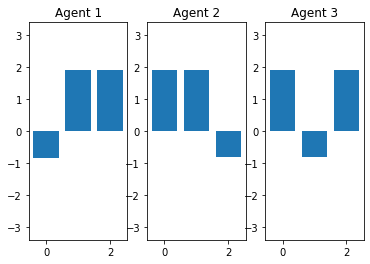

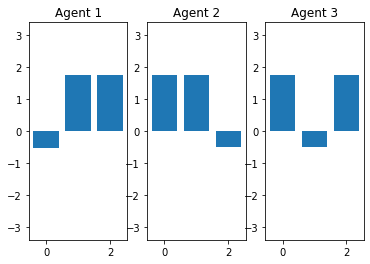

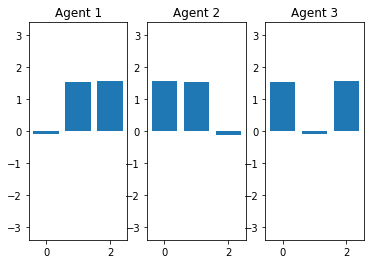

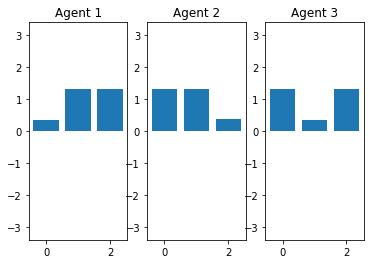

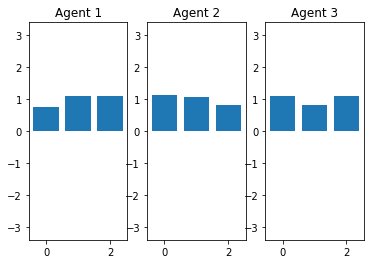

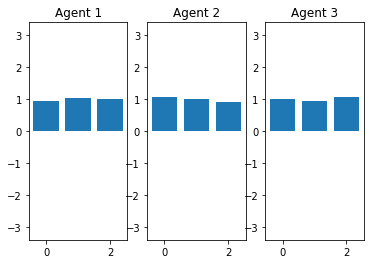

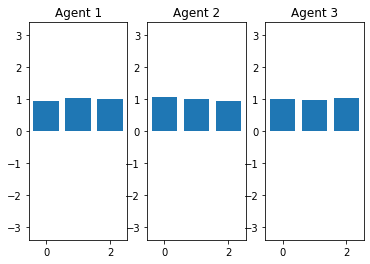

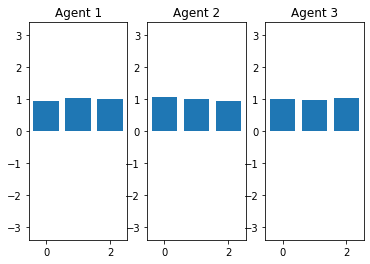

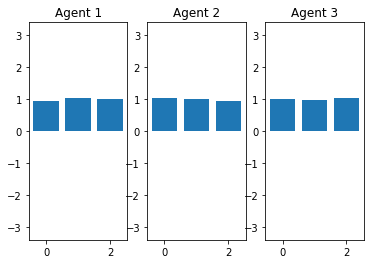

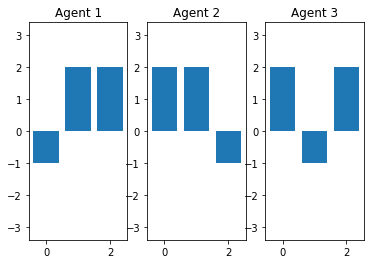

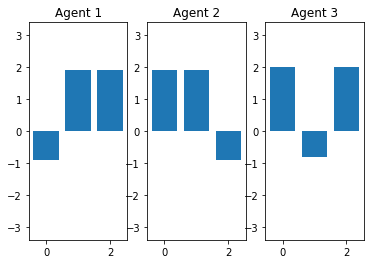

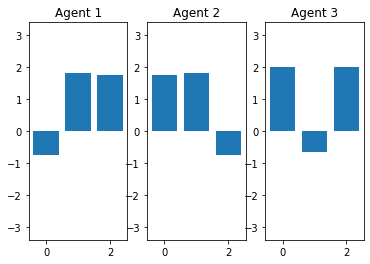

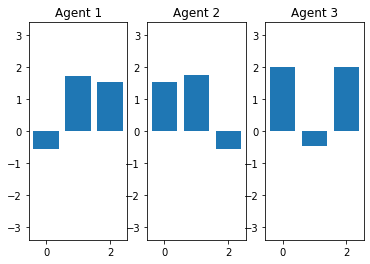

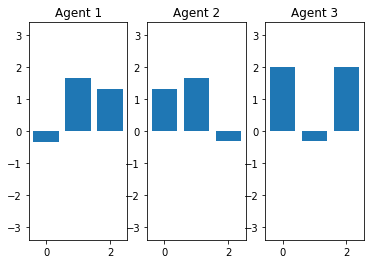

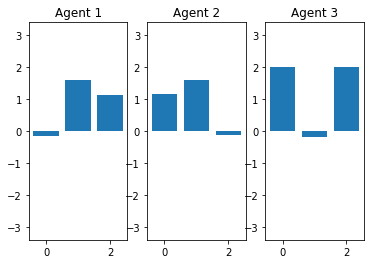

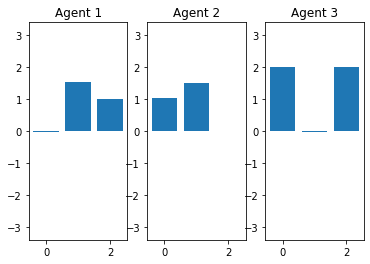

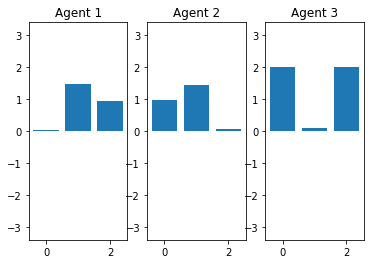

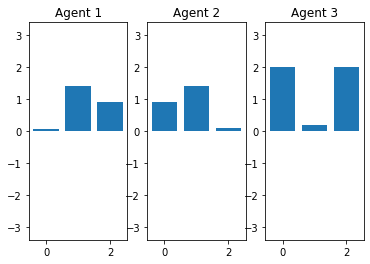

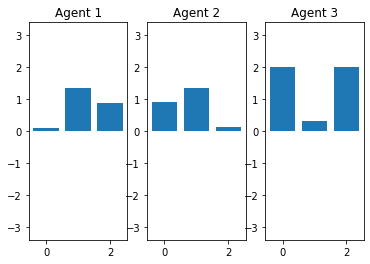

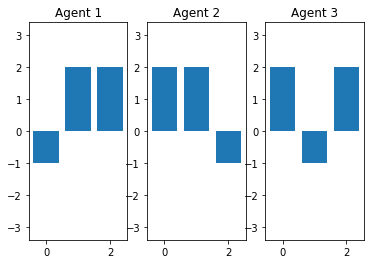

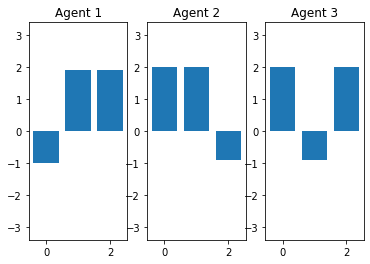

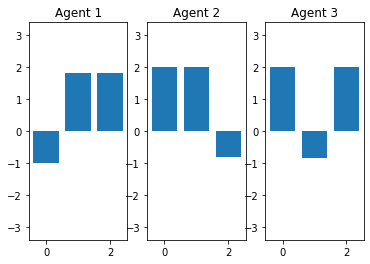

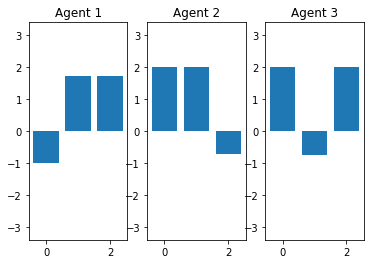

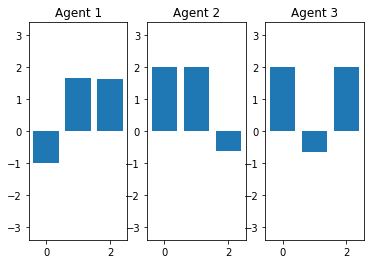

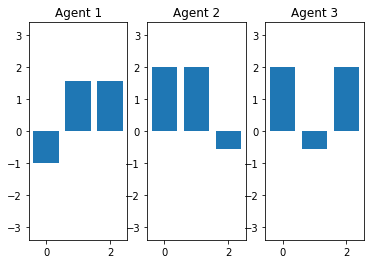

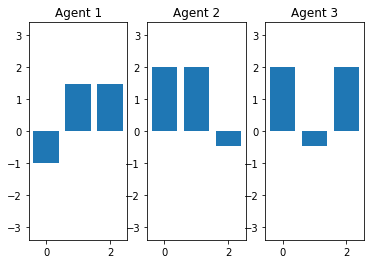

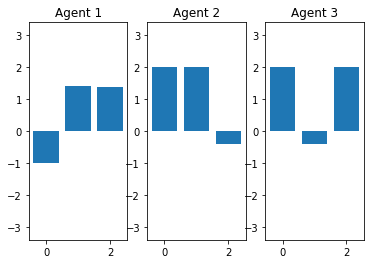

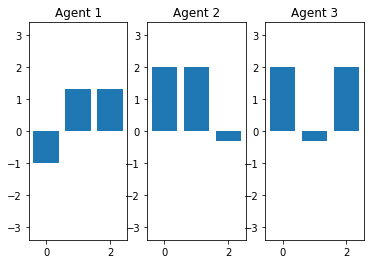

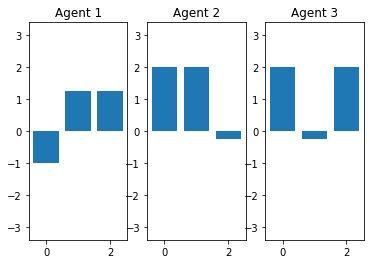

In [22]:
beta = 0.1
r = 0.1
alpha = 0
n_iter = 10
state = STATE_E
print('state:\n', state)
result = analyse(state, beta, r, alpha, n_iter)

In [23]:
env_D = result[1][0]
env_E = result[1][1]
env_F = result[1][2]

ut_max_pers_nices = -1 * env_D.hist_ut_agents[2][-1] #positive
ut_pers_3egoist = -1 * env_D.hist_ut_agents[0][0] #positive  
ut_pers_1egoist = -1 * env_E.hist_ut_agents[2][-1] #positive
ut_pers_2egoist = -1 * env_F.hist_ut_agents[0][-1] #positive

ic = ut_max_pers_nices-ut_pers_1egoist
sf = ut_pers_2egoist - ut_pers_3egoist

print(ic, sf)

print(ut_max_pers_nices, ut_pers_1egoist, ut_pers_2egoist, ut_pers_3egoist)

-0.3110836167707154 -0.4182119472833863
3.2970176095182904 3.6081012262890058 2.3543767899563948 2.772588737239781


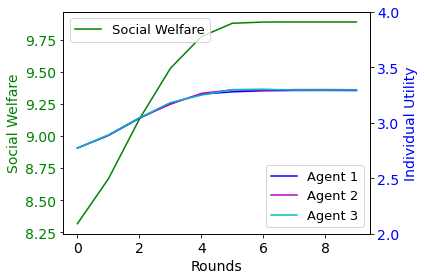

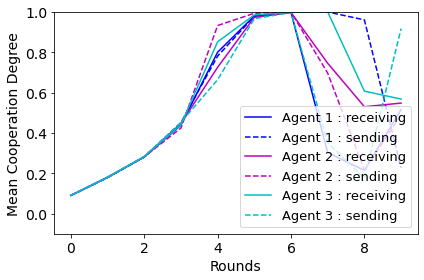

In [24]:
affiche(env_D, 'One_egoist', 2, 4, -0.1, 1)

In [25]:
def do_experiments(experiments):
    output = []
    for experiment in experiments:
        beta, r, alpha = experiment
        N_iter = 15
        a = analyse(STATE_E, beta, r, alpha, N_iter)
        output.append(a)
    
    return output

In [26]:
experiments = [
    # beta, r, alpha
    (0.1, 0.05, 0), 
    (0.1, 0.02, 0)
]

experiments_2 = [
    # beta, r, alpha
    (0.1, 0.05, 0),
    (0.1, 0.02, 0),
    (0.3, 0.1, 0),
    (0.5, 0.1, 0),
    (0.7, 0.1, 0),
    (0.1, 0.1, 0.3),
    (0.1, 0.1, 0.5),
    (0.1, 0.1, 0.7)
]

Stopping search: Swarm best objective change less than 1e-08
Env A, episode  0
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.871077969868212
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.045 0.045 0.045]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.045 0.045 0.045]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.045 0.045 0.045]

coop_degrees:
 [[0.045 0.045 0.045]
 [0.045 0.045 0.045]
 [0.045 0.045 0.045]]
demands:
 [[ 1.91728808 -0.95871023 -0.95857787]
 [-0.93641523 -0.99993064  1.93634572]
 [-0.96174437  1.93268997 -0.97094583]]
agents_demands
 [[1.91728808 0.         0.        ]
 [0.         0.         1.93634572]
 [0.         1.93268997 0.        ]]
agents_offers
 [[-0.          0.95871023  0.95857787]
 [ 0.93641523  0.9999

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [1. 0. 1.]
coop deg negociated  [0.96346389 0.05       0.96624764]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [1. 1. 0.]
coop deg negociated  [0.96366592 0.95904325 0.05      ]

coop_degrees:
 [[0.05       0.96459047 0.96279222]
 [0.96346389 0.05       0.96624764]
 [0.96366592 0.95904325 0.05      ]]
demands:
 [[ 0.17784146 -0.07656279 -0.10127869]
 [-0.1011943  -0.09617178  0.19736607]
 [-0.06839278  0.20028938 -0.13189669]]
agents_demands
 [[0.17784146 0.         0.        ]
 [0.         0.         0.19736607]
 [0.         0.20028938 0.        ]]
agents_offers
 [[-0.          0.07656279  0.10127869]
 [ 0.1011943   0.09617178 -0.        ]
 [ 0.06839278 -0.          0.13189669]]
Env A, episode  8
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.885950244195394
Stopping search: Swarm best objective change less than 1e-08
Agent  0


Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.13568586 0.05040258 0.05      ]

coop_degrees:
 [[0.05       0.90751662 0.990595  ]
 [0.05010638 0.05       0.05110193]
 [0.13568586 0.05040258 0.05      ]]
demands:
 [[ 7.09666348e-05 -6.02874166e-05 -1.18652919e-05]
 [-1.71707843e-02  3.46278768e-03  1.37079712e-02]
 [ 4.05894334e-05  2.20375798e-05 -6.29137501e-05]]
agents_demands
 [[7.09666348e-05 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.46278768e-03 1.37079712e-02]
 [4.05894334e-05 2.20375798e-05 0.00000000e+00]]
agents_offers
 [[-0.00000000e+00  6.02874166e-05  1.18652919e-05]
 [ 1.71707843e-02 -0.00000000e+00 -0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00  6.29137501e-05]]
Env B, episode  0
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.875012928060952
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated

/home/xavier/sharing_resources/sharing_resources/lib/python3.6/site-packages/ipykernel_launcher.py:189: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.21358092 0.        ]
coop deg negociated  [0.04999995 0.24980523 0.04999995]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.21337485 0.         0.        ]
coop deg negociated  [0.24919257 0.04999995 0.04999995]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.05590435 0.0539111  0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.04999995 0.24980523 0.04999995]
 [0.24919257 0.04999995 0.04999995]
 [0.         0.         0.        ]]
demands:
 [[ 1.33838285 -0.82627216 -0.51211125]
 [-0.50968618 -0.80227384  1.31196002]
 [-0.77898175  1.56739133 -0.78840965]]
agents_demands
 [[1.33838285 0.         0.        ]
 [0.         0.         1.31196002]
 [0.         1.56739133 0.        ]]
agents_offers
 [[-0.          0.82627216  0.51211125]
 [ 0.50968618  0.80227384 -0.        ]
 [ 0.778981

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.05154711 0.05174291 0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.05       0.10135876 0.05      ]
 [0.1058218  0.05       0.05      ]
 [0.         0.         0.        ]]
demands:
 [[ 0.77634632 -0.61044468 -0.16590173]
 [-0.1619349  -0.6212469   0.78318057]
 [-0.60378548  1.27628904 -0.67250527]]
agents_demands
 [[0.77634632 0.         0.        ]
 [0.         0.         0.78318057]
 [0.         1.27628904 0.        ]]
agents_offers
 [[-0.          0.61044468  0.16590173]
 [ 0.1619349   0.6212469  -0.        ]
 [ 0.60378548 -0.          0.67250527]]
Env B, episode  13
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.847767962718933
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.04398363 0.        ]
coop deg negociated  [0.05       0.09274188 0.05      ]

Stopping search: Swarm best objective change 

Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.04999995 0.04999995 0.04999995]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.05120428 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.05069404 0.         0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.04999995 0.04999995 0.04999995]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
demands:
 [[ 1.77694858 -0.8893218  -0.88762682]
 [-0.90326727 -0.87335793  1.77662514]
 [-0.87919836  1.77168082 -0.89248252]]
agents_demands
 [[1.77694858 0.         0.        ]
 [0.         0.         1.77662514]
 [0.         1.77168082 0.        ]]
agents_offers
 [[-0.          0.8893218   0.88762682]
 [ 0.90326727  0.87335793 -0.        ]
 [ 0.87919836 -0.          0.89248252]]
Env C, episode  6
S

Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.05 0.05 0.05]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.05258764 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.05038113 0.         0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.05 0.05 0.05]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
demands:
 [[ 1.5856593  -0.79830297 -0.78735635]
 [-0.76991857 -0.76240338  1.53232187]
 [-0.74723982  1.56310177 -0.81586273]]
agents_demands
 [[1.5856593  0.         0.        ]
 [0.         0.         1.53232187]
 [0.         1.56310177 0.        ]]
agents_offers
 [[-0.          0.79830297  0.78735635]
 [ 0.76991857  0.76240338 -0.        ]
 [ 0.74723982 -0.          0.81586273]]
Env C, episode  14
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.

Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.878881383542186
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.13929132 0.13920293]
coop deg negociated  [0.02       0.15295181 0.15372066]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.13389932 0.         0.13779005]
coop deg negociated  [0.14808177 0.02       0.15098756]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.14961102 0.13519624 0.        ]
coop deg negociated  [0.16246066 0.14921083 0.02      ]

coop_degrees:
 [[0.02       0.15295181 0.15372066]
 [0.14808177 0.02       0.15098756]
 [0.16246066 0.14921083 0.02      ]]
demands:
 [[ 1.26039361 -0.60675543 -0.65363821]
 [-0.63968767 -0.63437614  1.27406379]
 [-0.61984647  1.25154379 -0.63169734]]
agents_demands
 [[1.26039361 0.         0.        ]
 [0.         0.         1.27406379]
 [0.         1.25154379 0.   

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [1. 0. 1.]
coop deg negociated  [0.99828051 0.02       0.99950904]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [1. 1. 0.]
coop deg negociated  [0.99933096 0.99937017 0.02      ]

coop_degrees:
 [[0.02       0.99914337 0.99746448]
 [0.99828051 0.02       0.99950904]
 [0.99933096 0.99937017 0.02      ]]
demands:
 [[ 4.70420005e-03 -5.28810727e-03  5.83435377e-04]
 [-1.74726407e-03  9.58592702e-05  1.65139602e-03]
 [-7.44629328e-03  1.10544969e-02 -3.60840278e-03]]
agents_demands
 [[4.70420005e-03 0.00000000e+00 5.83435377e-04]
 [0.00000000e+00 9.58592702e-05 1.65139602e-03]
 [0.00000000e+00 1.10544969e-02 0.00000000e+00]]
agents_offers
 [[-0.          0.00528811 -0.        ]
 [ 0.00174726 -0.         -0.        ]
 [ 0.00744629 -0.          0.0036084 ]]
Env A, episode  14
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.8867531951586

Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.875163197964644
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.10589059 0.        ]
coop deg negociated  [0.02       0.12192392 0.02      ]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.10016601 0.         0.        ]
coop deg negociated  [0.11696184 0.02       0.02      ]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.02093946 0.01972122 0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.02       0.12192392 0.02      ]
 [0.11696184 0.02       0.02      ]
 [0.         0.         0.        ]]
demands:
 [[ 1.56270269 -0.86990824 -0.6927945 ]
 [-0.67500358 -0.88908572  1.5640893 ]
 [-0.89372126  1.77545077 -0.88173082]]
agents_demands
 [[1.56270269 0.         0.        ]
 [0.         0.         1.5640893 ]
 [0.         1.77545077 0.        ]]
agents_offers
 [

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.05861656 0.         0.        ]
coop deg negociated  [0.07900003 0.02       0.02      ]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.01936357 0.0197688  0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.02       0.0777402  0.02      ]
 [0.07900003 0.02       0.02      ]
 [0.         0.         0.        ]]
demands:
 [[ 1.11353258 -0.77369582 -0.33983681]
 [-0.31921526 -0.80578965  1.1250049 ]
 [-0.8098276   1.65129028 -0.84146275]]
agents_demands
 [[1.11353258 0.         0.        ]
 [0.         0.         1.1250049 ]
 [0.         1.65129028 0.        ]]
agents_offers
 [[-0.          0.77369582  0.33983681]
 [ 0.31921526  0.80578965 -0.        ]
 [ 0.8098276  -0.          0.84146275]]
Env B, episode  14
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.867122283959157
Stopping search: Swarm best objective change 

Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.871832762599789
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.02 0.02 0.02]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.02011125 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.01986272 0.         0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.02 0.02 0.02]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
demands:
 [[ 1.8592968  -0.94756547 -0.91173667]
 [-0.93322842 -0.93245529  1.86568367]
 [-0.92361085  1.85014624 -0.92653541]]
agents_demands
 [[1.8592968  0.         0.        ]
 [0.         0.         1.86568367]
 [0.         1.85014624 0.        ]]
agents_offers
 [[-0.          0.94756547  0.91173667]
 [ 0.93322842  0.93245529 -0.        ]
 [ 0.92361085 -0.          0.92653541]]
Env

Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.02 0.02 0.02]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.02050991 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.0200757 0.        0.       ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.02 0.02 0.02]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
demands:
 [[ 1.76127939 -0.92450655 -0.83679196]
 [-0.89908888 -0.8742457   1.77333455]
 [-0.88792744  1.74341543 -0.85548801]]
agents_demands
 [[1.76127939 0.         0.        ]
 [0.         0.         1.77333455]
 [0.         1.74341543 0.        ]]
agents_offers
 [[-0.          0.92450655  0.83679196]
 [ 0.89908888  0.8742457  -0.        ]
 [ 0.88792744 -0.          0.85548801]]
3.292583369127313 3.170136778157247 2.6398489976638224 2.772588737239781


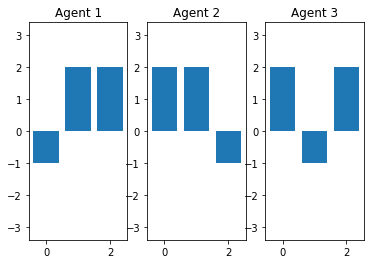

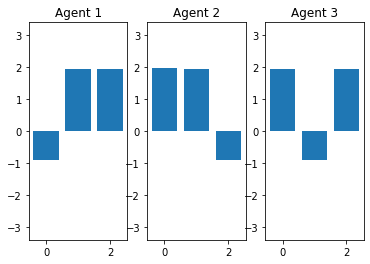

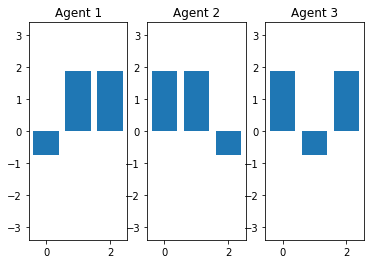

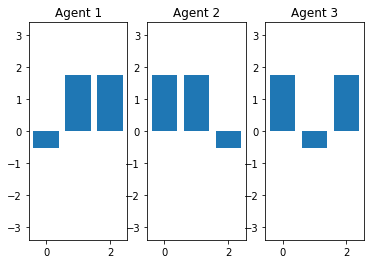

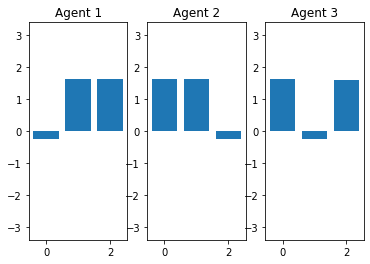

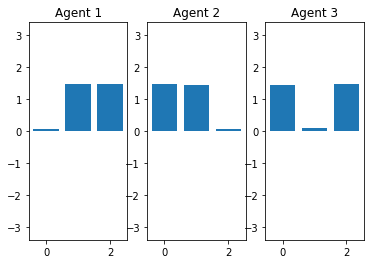

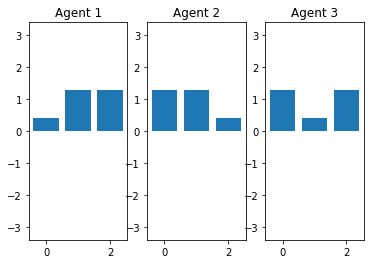

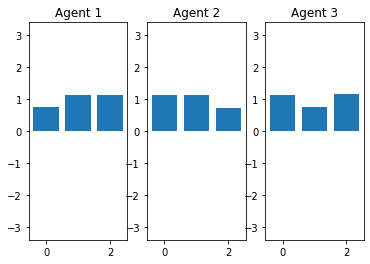

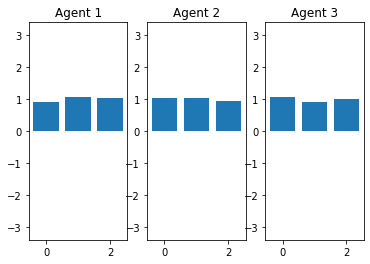

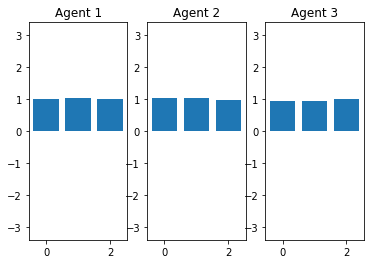

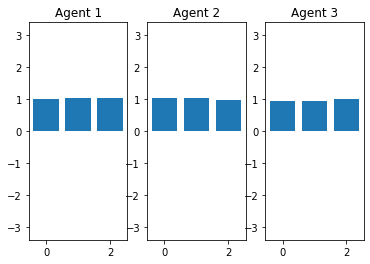

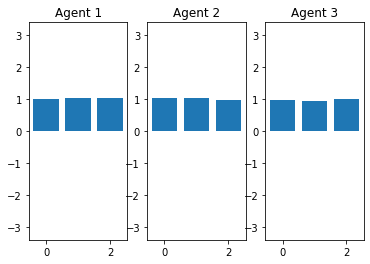

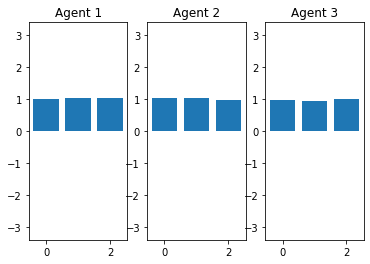

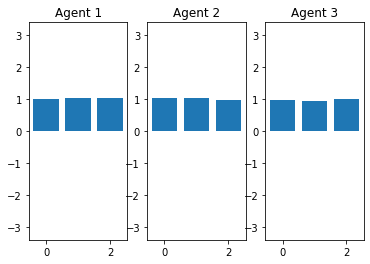

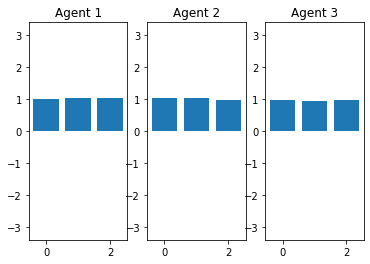

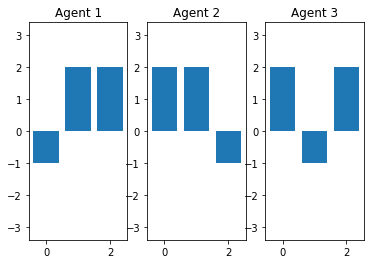

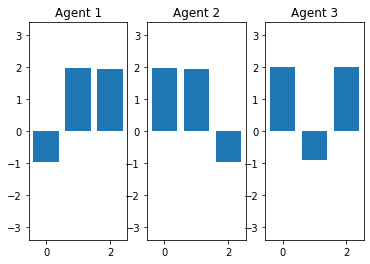

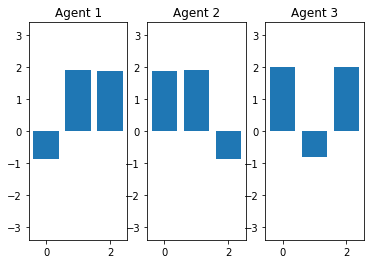

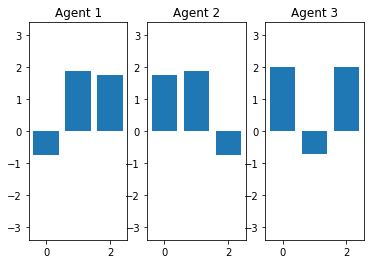

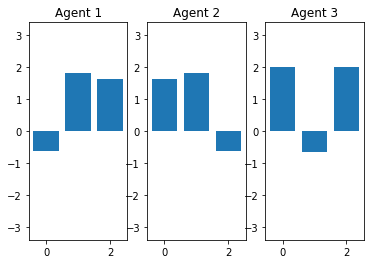

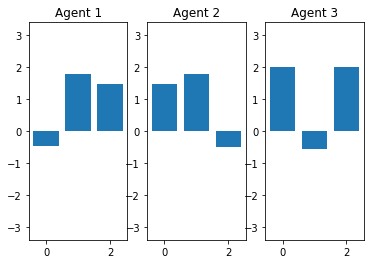

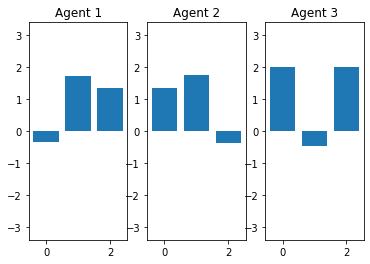

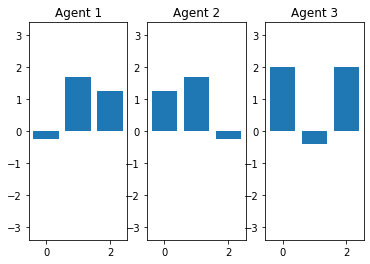

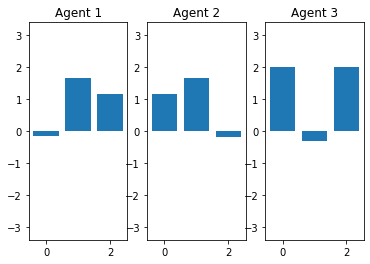

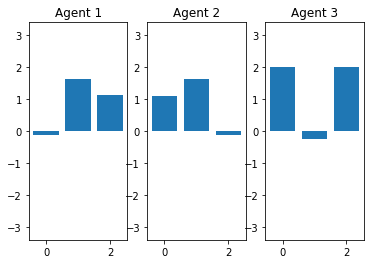

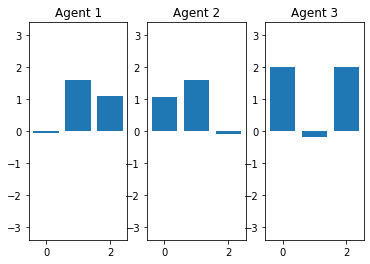

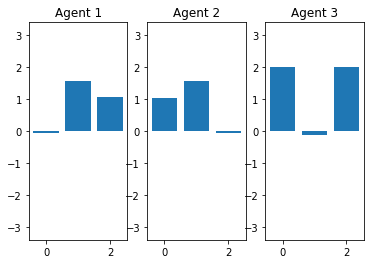

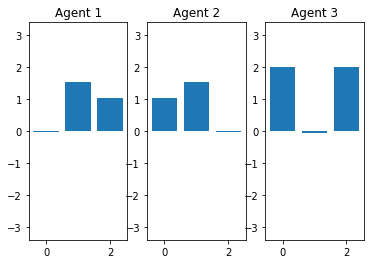

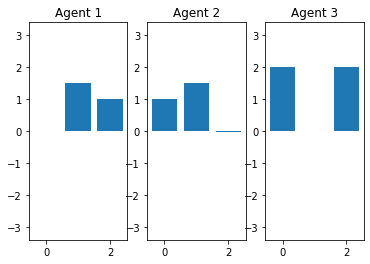

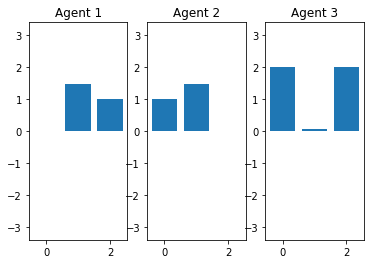

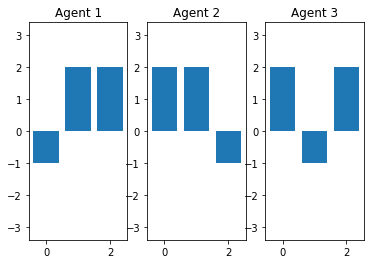

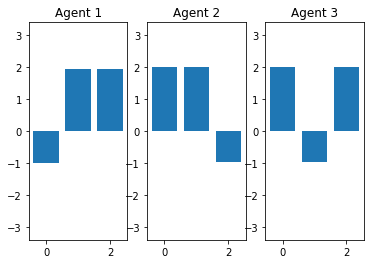

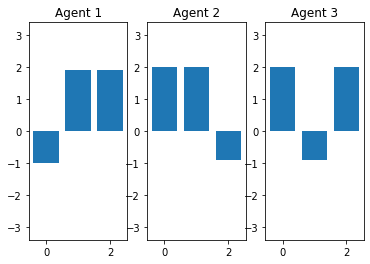

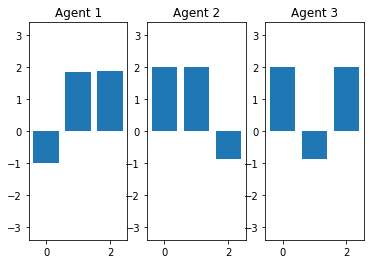

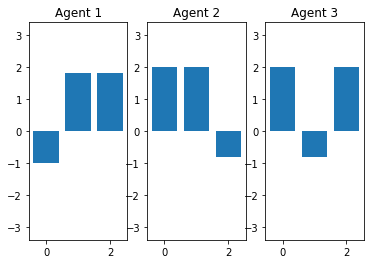

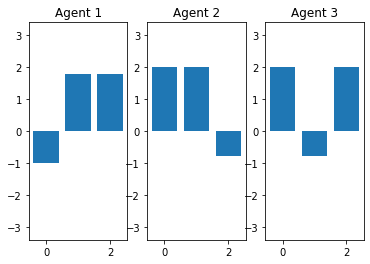

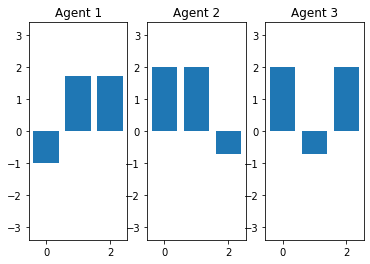

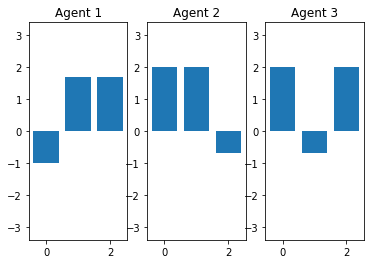

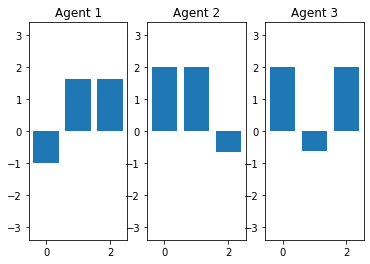

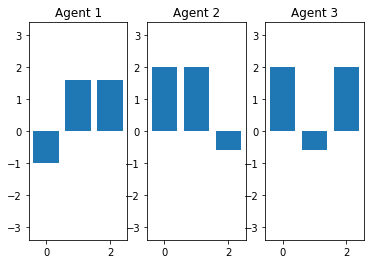

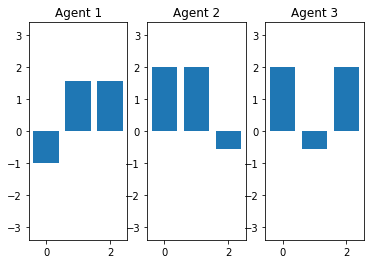

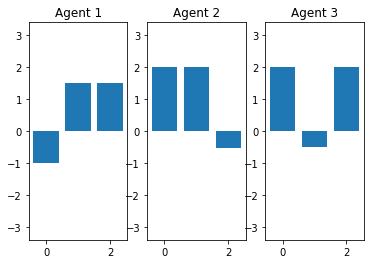

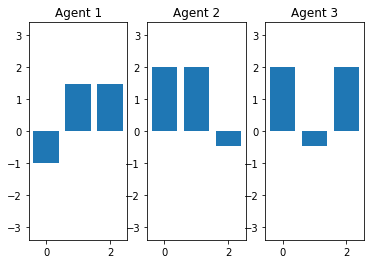

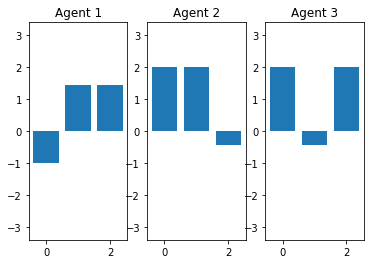

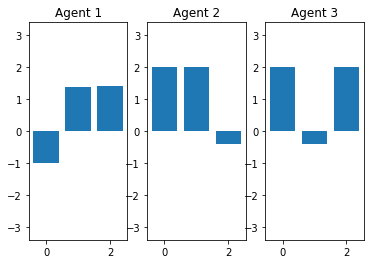

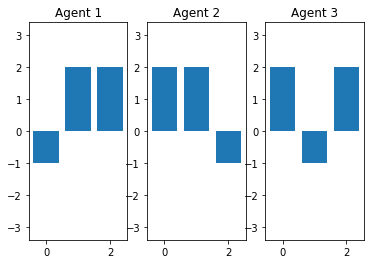

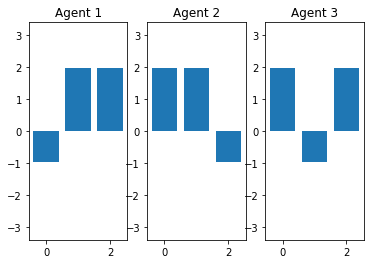

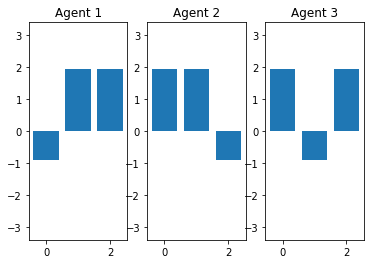

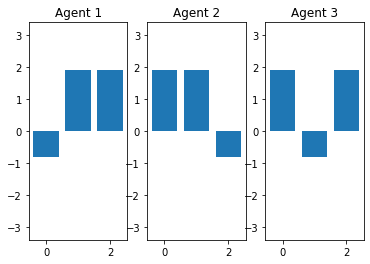

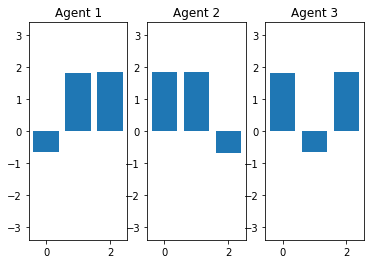

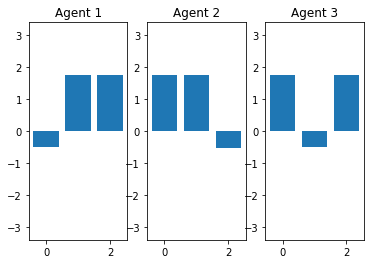

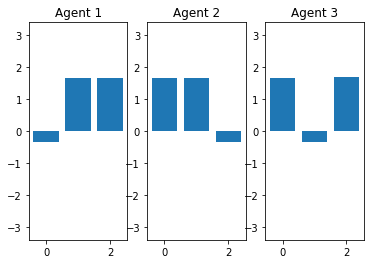

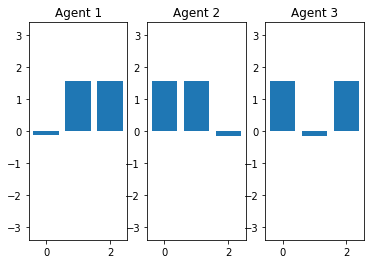

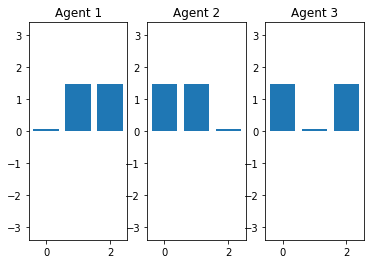

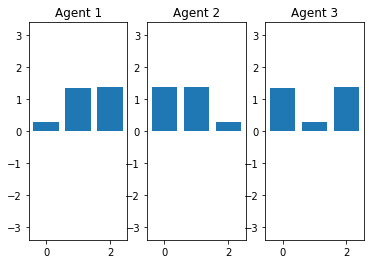

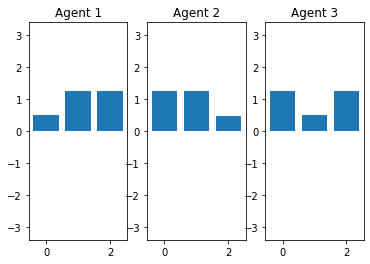

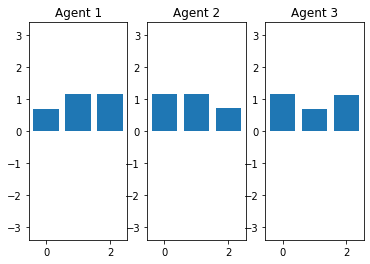

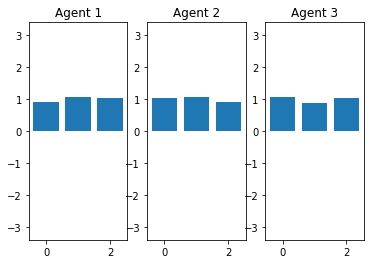

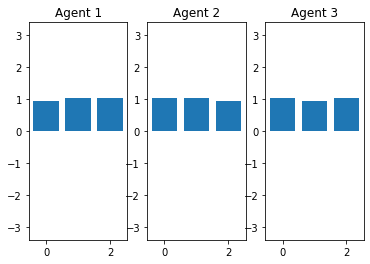

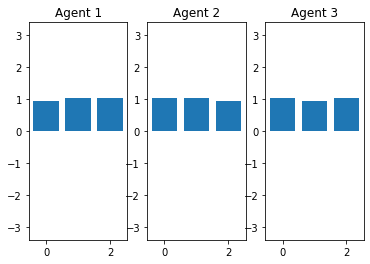

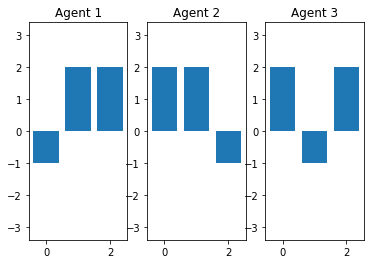

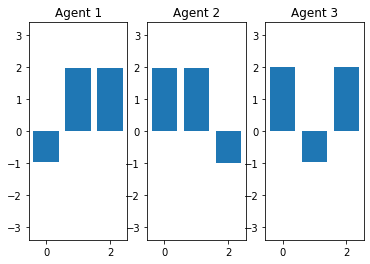

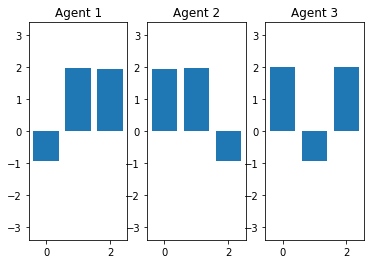

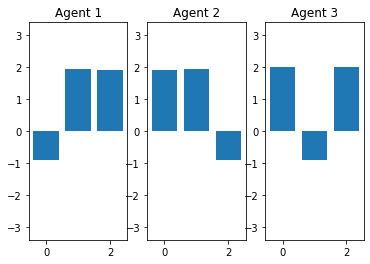

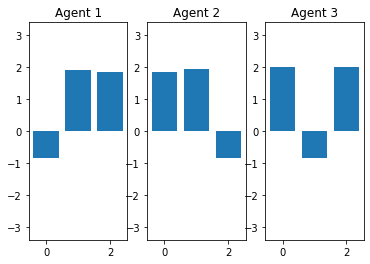

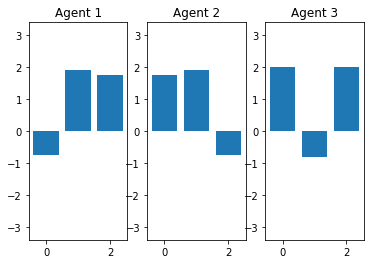

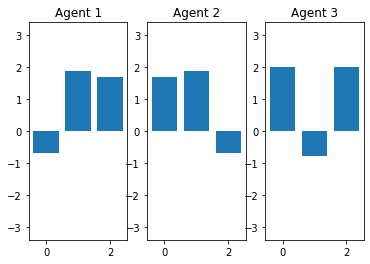

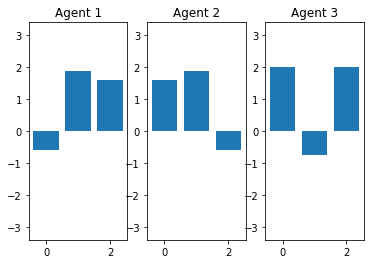

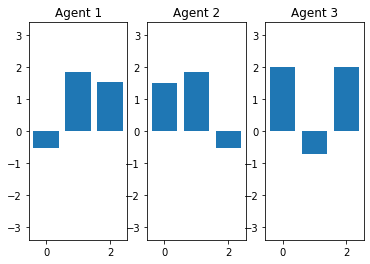

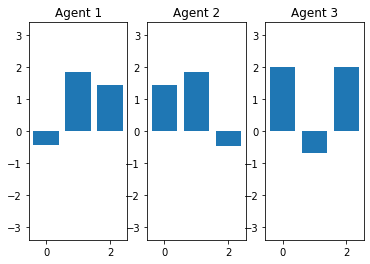

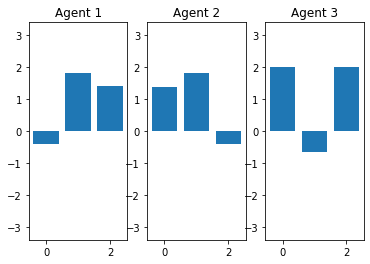

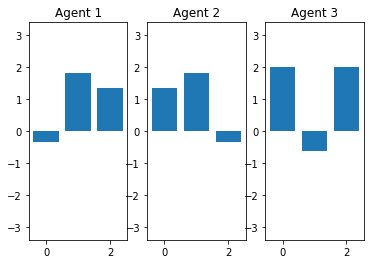

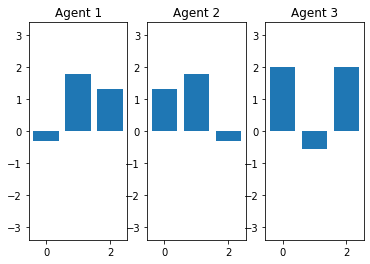

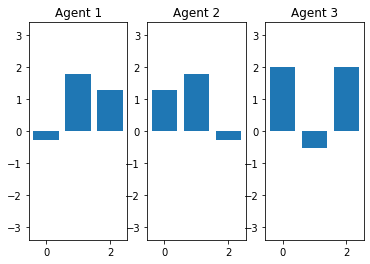

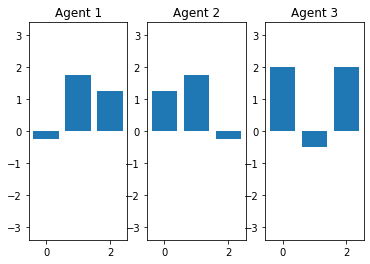

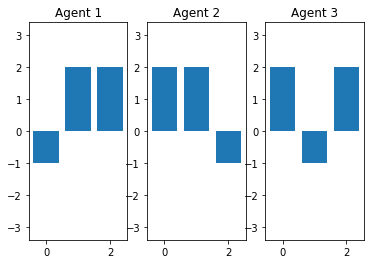

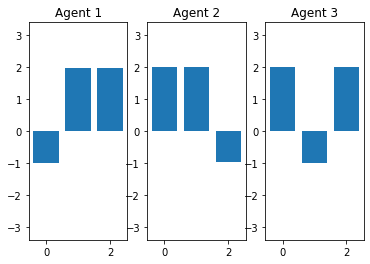

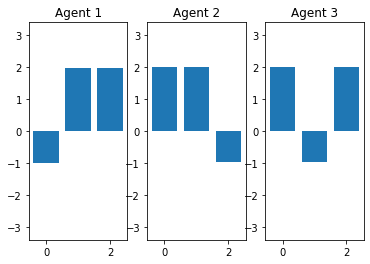

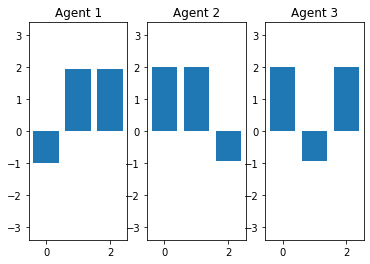

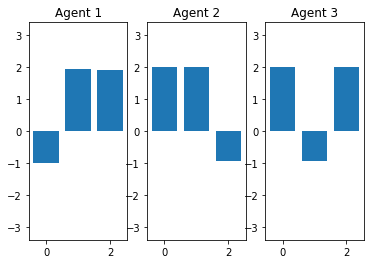

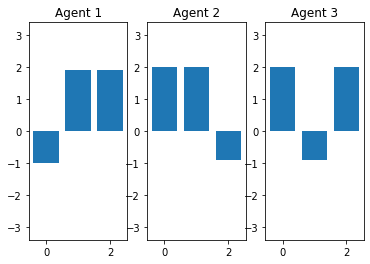

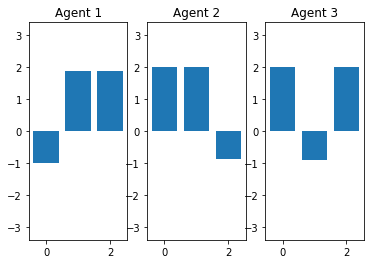

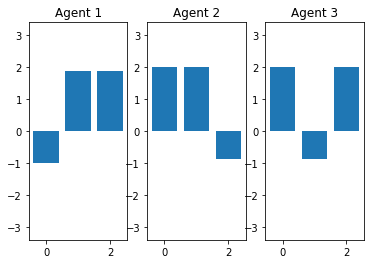

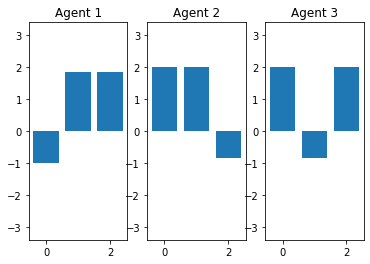

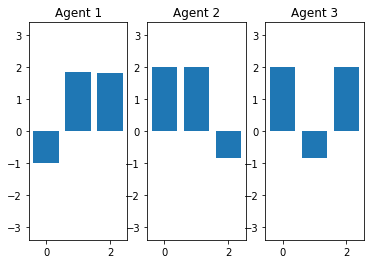

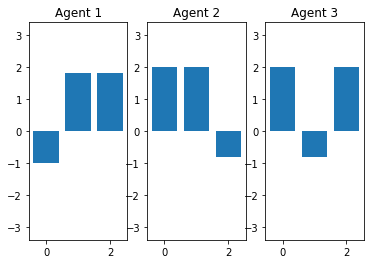

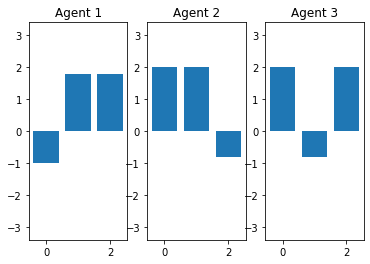

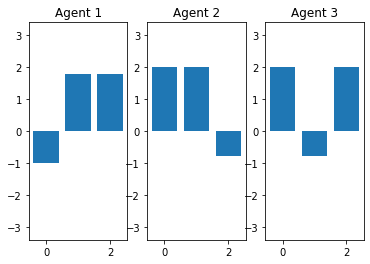

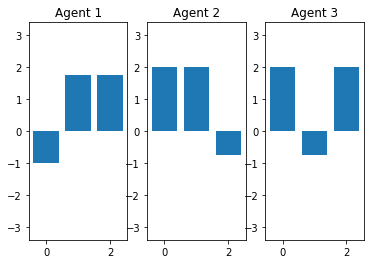

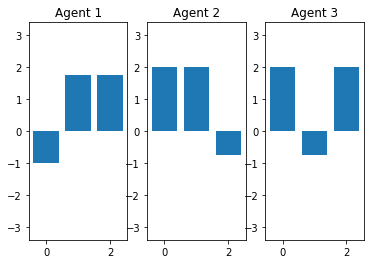

In [27]:
output = do_experiments(experiments)

In [28]:
for x in output:
    param, _, e, sp, utN, ut1E, ut2E, ut3E = x
    print(param, e, sp, ut1E, ut2E)

[0.1, 0.05, 0] 1 0.5943470156350903 3.5013080321552406 2.4447250033163686
[0.1, 0.02, 0] 1 0.40474948882114276 3.170136778157247 2.6398489976638224
